In [4]:
import rebound, numpy as np, matplotlib as mpl
#mpl.use('Agg') # found here:https://stackoverflow.com/questions/4931376/generating-matplotlib-graphs-without-a-running-x-server
import matplotlib.pyplot as plt, time as tiempo, math, sys

import subprocess 
def ding(): 
    """
    This is sometimes added to the end of code that takes a long time to run,
    so that I know when it is completed.
    It requires an mp3 file named "ding.mp3" in the same directory as this file.
    """
    subprocess.call(["afplay","ding.mp3"])

sim = rebound.Simulation()
tau = 2*np.pi

In [5]:
def ttor(R0 = 5e-4): #two to one resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 5**(1/3)*0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=2**(2/3), f=np.pi, r=R0) 
    return sim

def tttr(R0 = 5e-4): #two to three resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=2**(2/3), r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=3**(2/3), f=np.pi, r=R0) 
    return sim

def nor(R0 = 5e-4): #no resonance (initially at least)
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    sim.add(m=1) #creates a star of mass 1
    #R0 = .02
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=1.8, f=np.pi, r=R0) #use .1 mass to show the planets having a large effect on each other
    return sim
    
def resonance_counter(data, base = 1): # data should be realtive x values or y values
    innerplanetcount = 0
    outerplanetcount = 0
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        if x[0] < 0 and data[i+1][0] > 0:
            innerplanetcount += 1
        if x[1] < 0 and data[i+1][1] > 0:
            outerplanetcount += 1
    R = innerplanetcount/outerplanetcount
    print(R)
    R = R*base
    if R == int(R):
        R = int(R)
    print("The outer planet revolved", outerplanetcount, "times.")
    print("The inner planet revolved", innerplanetcount, "times.")
    print("They are in a {}:{} resonance.".format(base, R))
     
def rand_powerlaw(slope, min_v, max_v): #some distribution functions
    #https://rebound.readthedocs.io/en/latest/ipython/PrimordialEarth.html
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum
def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def quickplot(sim): #this uses matplotlib to plot the orbit, instead of rebound
    coords = np.zeros((2,sim.N))
    for i in range(sim.N):
        coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.scatter(coords[0],coords[1],marker=".",linewidth=0)
    for i in range(sim.N_active):
        ax.scatter(sim.particles[i].x,sim.particles[i].y); # Planet
        
def my_merge(sim_pointer, collided_particles_index):
    
    #https://rebound.readthedocs.io/en/latest/ipython/User_Defined_Collision_Resolve.html
    #or
    #https://rebound.readthedocs.io/en/latest/ipython_examples/User_Defined_Collision_Resolve/
    
    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i1 = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.
    j1 = collided_particles_index.p2
    
    if ps[i1]==0 and ps[j1]==0:
        return 0
    else:
        if ps[i1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=j1
            l=i1
            destroyi1=True
        if ps[j1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=i1
            l=j1
            destroyi1=False
            
        '''fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
        ax.set_title("Merging particle {} into {}".format(j, i))
        ax.text(ps[k].x, ps[k].y, "1");
        ax.text(ps[l].x, ps[l].y, "2")'''
        # So we plot the scenario exactly at the timestep that the collision function is triggered
        
        #print("merging particle", k,'into particle', l) #use this to know when collisions occur
        
        #particle_mass = Mtot_disk/N_pl
        particle_mass=1e-5
        particle_radius = 1e-5
        # Merging Logic
        total_mass = ps[k].m + particle_mass
        #merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

        # merged radius assuming a uniform density
        merged_radius = (ps[k].r**3 + particle_radius**3)**(1/3)

        #ps[k] = merged_planet   # update p1's state vector (mass and radius will need corrections)
        ps[k].m = total_mass    # update to total mass
        ps[k].r = merged_radius # update to joined radius
        
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1 #after adding mass
        #to a particle, we must recalculate Jacobi coordinates in order to recieve
        #physical values. Note that this code should be commented out if safemode is on.
        
        if destroyi1:
            return 1 #destroys p1, which is the particle w/o mass
        else:
            return 2 #destroys p2, which is the particle w/o mass
     
    
def masslist_txt(masslist,filepath,sim = None, write_type = 'a'):
    """
    Saves the masslists into a formatted txt file.
    """
    
    def avg(lst):
        sum = 0
        for i in lst:
            sum += i
        return sum / len(lst)

    masslistcopy = masslist.copy() # Don't want to edit the original data
    percentlist = list()
    message = ''
    message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        percentlist.append(percentdif)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'   
    message+= "\nAverage percent difference= {}.\n\n".format(avg(percentlist))
    with open(filepath,write_type) as file:
        file.write(sim+'\n')
        file.write(message)
        
def masslist_txt_append(masslist, filepath,sim = None,write_type = 'a', **kwargs):
    """
    Saves the masslists into a formatted txt file. This is similar to masslist_txt except 
    it lends itself better to appending. It is meant for simulations ran entirely separately.
    """
    
    def avg(listt):
        sum = 0
        for i in listt:
            sum += i
        return sum / len(listt)
    
    masslistcopy = masslist.copy() # Don't want to edit the original data
    message = ''
    if kwargs.get('first'):
        write_type = "w"
        message += sim+'\n'
        message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        #data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'
    with open(filepath,write_type) as file:
        file.write(message)
    if kwargs.get('last'):
        with open(filepath, "a") as file:
            file.write("\nAverage percent difference: {}"
                       .format(averagePercent(filepath)))
            file.write("\n"+"#"*40)
        
def masslist_read(filePath):
    """
    Inverse of masslist_txt()
    """
    with open(filePath,'r') as datafile:
        contents = datafile.read()
    contents = contents.split()
    finalList = []
    for index,value in enumerate(contents):
        try:
            value = float(value)
            finalList.append(value)
        except:
            pass
    return finalList

def avg(listt, **kwargs):
    sum = 0
    if kwargs.get('positive'):
        for i in listt:
            if i >= 0:
                sum += i
        return sum / len(listt)
    for i in listt:
        sum += i
    return sum / len(listt)

def averagePercent(filePath):
    dataList = masslist_read(filePath)
    percentList = []
    for i in range(2,len(dataList),4):
        percentList.append(dataList[i])
    return avg(percentList)

def saveFigs(addOn = "", seed = 0, **kwargs):
    """
    This saves several types of graphs into a folder corresponsing to the seed.
    Optional ability to add on to the name of a file easily.
    NOTE: Depending on the stepnumber, some of these graphs may contain useless data,
    because for some data types the stepnumber needs to be very high.
    """
    if kwargs.get("test"):
        seed = "Tests"
    
    plt.clf() # clears any graphs
    quickplot(sim)
    plt.savefig("Figures/"+str(seed)+"/quickplot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim,slices=0.3,color=True)
    plt.savefig("Figures/"+str(seed)+"/reboundPlot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])
    plt.savefig("Figures/"+str(seed)+"/reboundPlotOnlyPlanets"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, eccs)
    plt.title('Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/Eccentricity"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, relative_x_value)
    plt.title('X Value From Star Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('X Value (AU)')
    plt.savefig("Figures/"+str(seed)+"/relativeXValue"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, masses)
    plt.title('Mass of Planets Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Mass (Solar Masses)')
    plt.savefig("Figures/"+str(seed)+"/masses"+addOn+".pdf")
    
    plt.clf()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Planet Positions')
    axs[0].plot(list(position1[:,0]), list(position1[:,1]),'o')
    axs[1].plot(list(position2[:,0]), list(position2[:,1]),'o')
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.savefig("Figures/"+str(seed)+"/scatterPlotPositions"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, interplanetdistance)
    plt.title('Interplanetary Distance Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Distance (AU)')
    plt.savefig("Figures/"+str(seed)+"/interplanetaryDistance"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, particleNumber)
    plt.title('sim.N over time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('sim.N (AU)')
    plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidEccs[:,[i for i in range(0,simNi-2-1,50)]], linewidth=1)
    plt.title('Asteroid Eccentricity Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccs')
    plt.savefig("Figures/"+str(seed)+"/RoidEccs"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(EccsList, positive = True) for EccsList in asteroidEccs],linewidth=1)
    plt.title('Asteroid Eccentricity AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/RoidEccsAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins = 30
    plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)
    plt.savefig("Figures/"+str(seed)+"/RoidEccsHistoEnd"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,50)]], linewidth=1)
    # Does not plot every asteroid
    plt.title('Asteroid Semi Major Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxis"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(asteroidAUList) for asteroidAUList in asteroidAU],linewidth=1)
    plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins =30
    plt.hist([data for data in asteroidAU[0] if data > 0 and data < 5], num_bins)
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoStart"+addOn+".pdf")
    
    plt.clf()
    plt.hist([data for data in asteroidAU[-1] if data > 0 and data < 5], num_bins)
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoEnd"+addOn+".pdf")

In [6]:
def generatettor(simulation = ttor,seed = None, asteroidnumber = 1000):  
    sim = simulation()
    sim.N_active = sim.N

    sim.integrator = "ias15"
#     sim.integrator = "mercurius"
    #sim.ri_mercurius.hillfac = 3
    #sim.ri_ias15.min_dt = 0 # stes the minimum dt, default is 0. This should be specified on mercurius as well.
    #sim.integrator = "whfast"
    #sim.ri_whfast.corrector = 0 #zero order corrector for better speed
    #sim.ri_whfast.safe_mode = 0 #turns off safemode, *substantial* speed boost
    #sim.dt = 0.001*2*np.pi #mutiple by 2pi if in units such that G=1
    sim.testparticle_type = 0
    #sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = my_merge # a function that I made
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 100
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1

    N_pl = asteroidnumber                # Number of planetesimals
    Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
    m_pl = 0 #Mtot_disk / float(N_pl)    # Mass of each planetesimal
    r_pl = 2e-9 

    #seed = 0
    #46 is my most frequently used seed
    np.random.seed(seed) # by setting a seed we will reproduce the same simulation every time
    while sim.N < (N_pl + sim.N_active):
        #a = rand_powerlaw(0, 0.1, 3) 
        a = rand_uniform(.6,2.9)
        #e = rand_rayleigh(0.01) by default is 0
        e=0
        #inc = rand_rayleigh(0.005)
        inc=0
        f = rand_uniform(-np.pi,np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0], r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
        # Only add planetesimal if it's far away from the planet
        d1 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
        d2 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[2].xyz))
        d = min(d1,d2)
        if d>5e-4:
            sim.add(p)
    
    # Hash Creation
    ps = sim.particles
    ps[0].hash = "star"
    ps[1].hash = "innerPlanet"
    ps[2].hash = "outerPlanet"
    for i in range(3,sim.N): # this sets their hash to their starting particle number
        ps[i].hash = str(i)
    #

    sim.collision_resolve = my_merge

    #sim.move_to_com()
    E0 = sim.calculate_energy()
    #quickplot(sim)
    return sim
    
def quickcollect2(n, Ti, Tf, stepnumber, **kwargs): #collects orbital data on the first two bodies in a system
    initialtime = tiempo.monotonic()
#     n=2 #number of planets
#     T=80*2*np.pi #years of simulation
    # Planet variables
    global times, dist, relative_x_value,relative_y_value, eccs, position1, position2, \
    interplanetdistance, masses, particleNumber
    times = np.linspace(Ti,Tf,stepnumber)
    #diftimes = list()
    dist = np.zeros((len(times),n)) 
    relative_x_value = np.zeros((len(times),n))
    relative_y_value = np.zeros((len(times),n))
    eccs = np.zeros((len(times),n))
    position1 = np.zeros((len(times),2))
    position2 = np.zeros((len(times),2))
    interplanetdistance = np.zeros((len(times),1))
    particleNumber = np.zeros((len(times),1))
    masses = np.zeros((len(times),n))
    ps = sim.particles
    # Asteroid variables:
    global asteroidAU, asteroidEccs, simNi
    simNi = sim.N
    asteroidAU = np.zeros((len(times),simNi-n-1)) # n is the number of planets, 1 is the number of stars
    asteroidEccs = np.negative(np.ones((len(times),simNi-n-1)))
    for i, t in enumerate(times):
        sim.integrate(t)
        print("| {} time = {} years | {} particles | {} step number |\n\
| {} second | {} minutes.\n"\
        .format(t,t/tau,sim.N,i,round((tiempo.monotonic()-initialtime),1)\
        ,round((tiempo.monotonic()-initialtime)/60,1)))
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        #diftimes.append(sim.t+dT)
        #if i== int(stepnumber/2):
            #print("1/2 done at {} seconds.".format(int(tiempo.time() - initialtime)))
        ps = sim.particles
        interplanetdistance[i] = np.linalg.norm(np.array(ps[2].xyz)-np.array(ps[1].xyz))
        particleNumber[i] = sim.N
        position1[i] = [ps[1].x,ps[1].y]
        position2[i] = [ps[2].x,ps[2].y]
        for planet in range(n):
            planetdif = planet+1
            dist[i,planet] = np.linalg.norm(np.array(ps[planetdif].xyz)-np.array(ps[0].xyz))
            relative_x_value[i,planet] = ps[planetdif].x - ps[0].x
            relative_y_value[i,planet] = ps[planetdif].y - ps[0].y
            eccs[i,planet] = ps[planetdif].e
            masses[i,planet] = ps[planetdif].m
        position1[i] = [relative_x_value[i,0],relative_y_value[i,0]]
        position2[i] = [relative_x_value[i,1],relative_y_value[i,1]]
        #### Data collection from asteroids:
        if kwargs.get("asteroidCollect"):
            for roidNumber in range(3,simNi):
                #print("index:{}, roidNumber: {}".format(index,roidNumber))
                index = roidNumber - n -1
                try:                    
                    asteroidAU[i,index] = ps[str(roidNumber)].a
                    asteroidEccs[i,index] = ps[str(roidNumber)].e
                except:
                    pass
        ####
    finaltime = tiempo.monotonic()
#     print('done')
    #print("{} done at {} seconds!".format((a+1)/10,int(finaltime-initialtime)))
    print("Done at {} seconds!".format((int(finaltime-initialtime))))
#     print("The inner planet ended with a mass of {}.".format(ps[1].m))
#     print("The outer planet ended with a mass of {}.".format(ps[2].m))
#     print("There are {} particles remaining.".format(sim.N))
    quickplot(sim)
    #ding()
    
def remove(AU, sim = sim):
    for i in reversed(range(sim.N)):
        ps = sim.particles
        if np.linalg.norm(np.array(ps[i].xyz)-np.array(ps[0].xyz)) > AU:
            sim.remove(i)

Steps: 100
Beginning seed 0.
| 0.0 time = 0.0 years | 103 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 6.346651825433926 time = 1.0101010101010102 years | 103 particles | 1 step number |
| 0.1 second | 0.0 minutes.

| 12.693303650867852 time = 2.0202020202020203 years | 103 particles | 2 step number |
| 0.2 second | 0.0 minutes.

| 19.039955476301778 time = 3.0303030303030303 years | 103 particles | 3 step number |
| 0.3 second | 0.0 minutes.

| 25.386607301735705 time = 4.040404040404041 years | 103 particles | 4 step number |
| 0.4 second | 0.0 minutes.

| 31.73325912716963 time = 5.050505050505051 years | 102 particles | 5 step number |
| 0.6 second | 0.0 minutes.

| 38.079910952603555 time = 6.0606060606060606 years | 102 particles | 6 step number |
| 0.6 second | 0.0 minutes.

| 44.426562778037486 time = 7.070707070707072 years | 102 particles | 7 step number |
| 0.7 second | 0.0 minutes.

| 50.77321460347141 time = 8.080808080808081 years | 102 particles | 8 step nu

| 463.3055832566766 time = 73.73737373737374 years | 96 particles | 73 step number |
| 6.1 second | 0.1 minutes.

| 469.6522350821105 time = 74.74747474747475 years | 96 particles | 74 step number |
| 6.2 second | 0.1 minutes.

| 475.9988869075445 time = 75.75757575757576 years | 96 particles | 75 step number |
| 6.3 second | 0.1 minutes.

| 482.3455387329784 time = 76.76767676767678 years | 96 particles | 76 step number |
| 6.3 second | 0.1 minutes.

| 488.69219055841234 time = 77.77777777777779 years | 96 particles | 77 step number |
| 6.4 second | 0.1 minutes.

| 495.03884238384626 time = 78.7878787878788 years | 96 particles | 78 step number |
| 6.4 second | 0.1 minutes.

| 501.3854942092802 time = 79.7979797979798 years | 96 particles | 79 step number |
| 6.5 second | 0.1 minutes.

| 507.7321460347141 time = 80.80808080808082 years | 96 particles | 80 step number |
| 6.5 second | 0.1 minutes.

| 514.078797860148 time = 81.81818181818183 years | 96 particles | 81 step number |
| 6.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

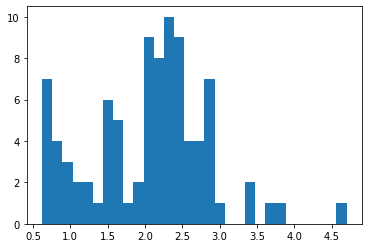

In [37]:
numberOfSims = 1 
endTime = 100 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.monotonic()
# try:
#     a = int(sys.argv[1])
# except IndexError:
#     print("#"*40)
#     print("\n"*3)
#     print("Sys.argv had an error! Setting the seed equal to 0!")
#     print("\n"*3)
#     print("#"*40)
a = 0
#
#for a in range(numberOfSims):
stepFrequency = 1 # how often should a step occur (years)
steps = int(endTime/stepFrequency) # Will round down to an integer
print(f"Steps: {steps}")
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 100)
quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = steps, asteroidCollect = True)
print("Masses {} and {}.".format(ps[1].m,ps[2].m))
print("Ending seed {}.\n".format(a))
pre_list = [ps[1].m, ps[2].m,a]
ttor_masses.append(pre_list)
#
BIGfinal = tiempo.monotonic()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
#masslist_txt(ttor_masses,'test.txt','ttor','w')
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))
#ding()
# try:
# 	if int(sys.argv[2]): # sys.argv=0 will mean this is the first data point, =1 is last
# 		first = False
# 		last = True
# 	else: 
# 		first = True
# 		last = False
# except IndexError: # if first or last not specified, it is a middle data point
# 	first = False
# 	last = False
first = False
last = False
#masslist_txt_append(ttor_masses,'Masslists/shortTests.txt','ttor','a', first = first, last = last)
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))

saveFigs(addOn = "testy", seed = a, test = True)

Text(0, 0.5, 'Eccs')

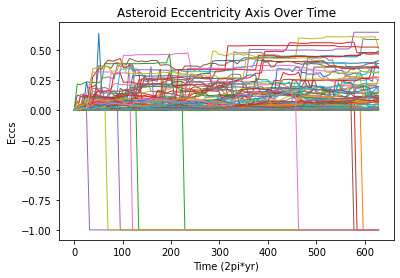

In [40]:
plt.clf()
plt.plot(times, asteroidEccs[:,[i for i in range(0,simNi-2-1,1)]], linewidth=1)
plt.title('Asteroid Eccentricity Axis Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Eccs')

(array([32.,  4.,  6.,  8.,  5.,  5.,  2.,  3.,  3.,  0.,  1.,  1.,  3.,
         0.,  3.,  1.,  4.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.]),
 array([0.00178841, 0.02342177, 0.04505514, 0.0666885 , 0.08832187,
        0.10995523, 0.1315886 , 0.15322196, 0.17485533, 0.19648869,
        0.21812205, 0.23975542, 0.26138878, 0.28302215, 0.30465551,
        0.32628888, 0.34792224, 0.36955561, 0.39118897, 0.41282234,
        0.4344557 , 0.45608907, 0.47772243, 0.4993558 , 0.52098916,
        0.54262252, 0.56425589, 0.58588925, 0.60752262, 0.62915598,
        0.65078935]),
 <BarContainer object of 30 artists>)

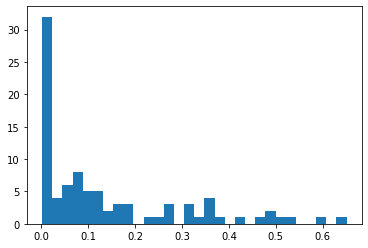

In [51]:
plt.clf()
num_bins = 30
plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)
plt.savefig("Figures/"+str(seed)+"/RoidEccsHistoEnd"+addOn+".pdf")

NameError: name 'seed' is not defined

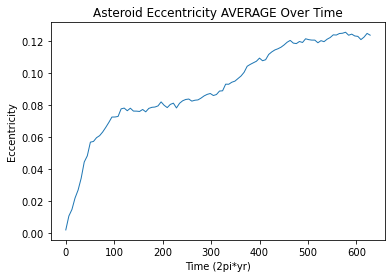

In [48]:
plt.clf()
plt.plot(times, [avg(EccsList, positive = True) for EccsList in asteroidEccs],linewidth=1)
plt.title('Asteroid Eccentricity AVERAGE Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Eccentricity')
plt.savefig("Figures/"+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")

(array([32.,  4.,  6.,  8.,  5.,  5.,  2.,  3.,  3.,  0.,  1.,  1.,  3.,
         0.,  3.,  1.,  4.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.]),
 array([0.00178841, 0.02342177, 0.04505514, 0.0666885 , 0.08832187,
        0.10995523, 0.1315886 , 0.15322196, 0.17485533, 0.19648869,
        0.21812205, 0.23975542, 0.26138878, 0.28302215, 0.30465551,
        0.32628888, 0.34792224, 0.36955561, 0.39118897, 0.41282234,
        0.4344557 , 0.45608907, 0.47772243, 0.4993558 , 0.52098916,
        0.54262252, 0.56425589, 0.58588925, 0.60752262, 0.62915598,
        0.65078935]),
 <BarContainer object of 30 artists>)

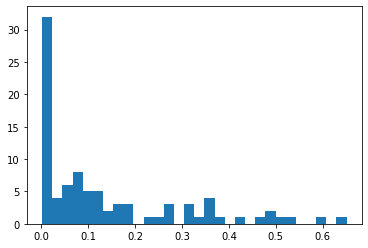

In [43]:
plt.clf()
num_bins =30
plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)

In [30]:
asteroidEccs

array([[0.00213095, 0.00227771, 0.00214434, ..., 0.00236732, 0.00212638,
        0.00163729],
       [0.00442119, 0.00427359, 0.00633507, ..., 0.0026959 , 0.00239909,
        0.0171412 ],
       [0.00239071, 0.00547465, 0.00531342, ..., 0.00245213, 0.00489385,
        0.02208477],
       ...,
       [0.39598914, 0.2095822 , 0.07939152, ..., 0.00702561, 0.31621795,
        0.14940208],
       [0.40471268, 0.20659113, 0.08032478, ..., 0.0030262 , 0.31651619,
        0.18105338],
       [0.4137051 , 0.19297719, 0.08334997, ..., 0.00249092, 0.31103032,
        0.1853824 ]])

Text(0, 0.5, 'Semi Major Axis (AU)')

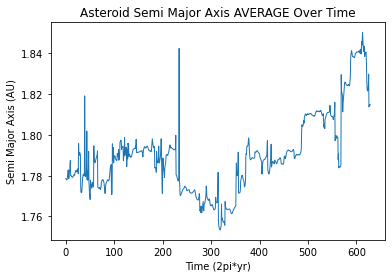

In [6]:
asteroidAUaverage = [avg(asteroidAUList) for asteroidAUList in asteroidAU]
plt.plot(times, asteroidAUaverage,linewidth=1)
plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Semi Major Axis (AU)')
#plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids

In [7]:
asteroidAUaverage = [avg(asteroidAUList) for asteroidAUList in asteroidAU]
asteroidAUaverage

[1.7785390782304518,
 1.7783406705292242,
 1.7780823035095505,
 1.7778878820771908,
 1.7780302210954775,
 1.7787941326966044,
 1.7799007717273903,
 1.781516799435002,
 1.7828486533593275,
 1.7785255972843288,
 1.778679323509837,
 1.7790439579096828,
 1.7824841165817602,
 1.7821660045375651,
 1.7859491091935835,
 1.7875240862716937,
 1.7800669138230247,
 1.7799214278495692,
 1.7799853234123975,
 1.7796564948198108,
 1.7794015525212534,
 1.779278424459155,
 1.779183089207437,
 1.7792449902790437,
 1.7795822126307002,
 1.7799686993644337,
 1.7802903051570118,
 1.78050242568058,
 1.7805565716467808,
 1.7802162892688025,
 1.7812677274583575,
 1.7814833831659547,
 1.7818457891744948,
 1.7825295182831502,
 1.7826255713568988,
 1.7820793706723712,
 1.7818137674676964,
 1.7818912481965001,
 1.7822550136568076,
 1.7833403990029248,
 1.7833534205420465,
 1.780977025216176,
 1.795799518096337,
 1.790383801989885,
 1.7899696485480028,
 1.7910994963926512,
 1.7912981214350046,
 1.7909465913990459,
 

array([[2, 4],
       [7, 9]])

Text(0, 0.5, 'sim.N (AU)')

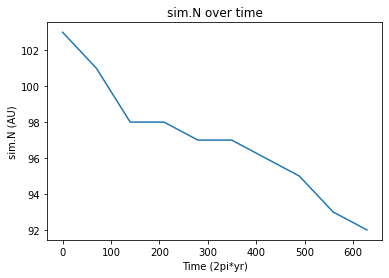

In [43]:
plt.clf()
plt.plot(times, particleNumber)
plt.title('sim.N over time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('sim.N (AU)')
plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")

In [134]:
def animate(N, T, sim): #this makes an animation of a system over time
    sim.integrate(0)
    interval = T/N
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    sim.move_to_com()
    end_timestep = N
    print ('The timestep is ', interval, 'years.')
    #stop = input('Is this suitable? (y/n)')
    #if stop == 'n':
        #sys.exit("Enter a higher N for a lower interval.")
    for i in range(N+1):
        sim.integrate(sim.t+interval)
        #fig, ax = rebound.OrbitPlot(sim,color=True,orbit_type='solid', unitlabel="[AU]",xlim=[-5,5],ylim=[-5,5])
        quickplot(sim)
        display()
        print (i, "timesteps,", i*interval, "years")
        print("The interval is", interval, 'years.')
        """if i == end_timestep/2:
            print("The current timestep is", i, ". This is a time of", i*interval,"years.")
            tf = input("Would you like to continue? (y/n)")
            if tf == 'n':
                break""" #I use these lines if I'm worried the total time is too high
        #plt.close(fig)
        plt.clf()
        clear_output(wait=True)
sim = generatettor(simulation = ttor,seed = None, asteroidnumber = 100)
animate(100,10, sim)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Eccentricity')

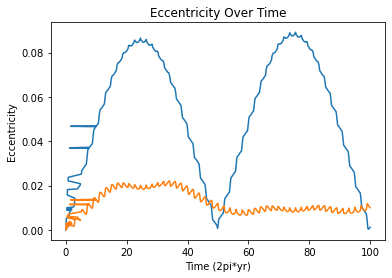

In [206]:
plt.clf()
plt.plot([i/tau for i in times], eccs)
plt.title('Eccentricity Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Eccentricity')

In [4]:
import os.path
os.path.isfile("Masslists/appendTest.txt")

True

In [ ]:
import os.path
os.path.isfile(fname)

In [34]:
np.negative(np.ones((2,3)))

array([[-1., -1., -1.],
       [-1., -1., -1.]])

In [35]:
np.ones((2,3))

array([[1., 1., 1.],
       [1., 1., 1.]])

Steps: 10000
Beginning seed 0.
| 0.0 time = 0.0 years | 3 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 0.6283813688548441 time = 0.1000100010001 years | 3 particles | 1 step number |
| 0.0 second | 0.0 minutes.

| 1.2567627377096882 time = 0.2000200020002 years | 3 particles | 2 step number |
| 0.0 second | 0.0 minutes.

| 1.8851441065645322 time = 0.3000300030003 years | 3 particles | 3 step number |
| 0.0 second | 0.0 minutes.

| 2.5135254754193763 time = 0.4000400040004 years | 3 particles | 4 step number |
| 0.0 second | 0.0 minutes.

| 3.1419068442742204 time = 0.5000500050005 years | 3 particles | 5 step number |
| 0.0 second | 0.0 minutes.

| 3.7702882131290645 time = 0.6000600060006 years | 3 particles | 6 step number |
| 0.0 second | 0.0 minutes.

| 4.398669581983908 time = 0.7000700070007 years | 3 particles | 7 step number |
| 0.0 second | 0.0 minutes.

| 5.027050950838753 time = 0.8000800080008 years | 3 particles | 8 step number |
| 0.0 second | 0.0 minutes.


| 285.91352282895406 time = 45.504550455045504 years | 3 particles | 455 step number |
| 0.2 second | 0.0 minutes.

| 286.5419041978089 time = 45.604560456045604 years | 3 particles | 456 step number |
| 0.2 second | 0.0 minutes.

| 287.1702855666637 time = 45.7045704570457 years | 3 particles | 457 step number |
| 0.2 second | 0.0 minutes.

| 287.7986669355186 time = 45.804580458045805 years | 3 particles | 458 step number |
| 0.2 second | 0.0 minutes.

| 288.42704830437344 time = 45.904590459045906 years | 3 particles | 459 step number |
| 0.2 second | 0.0 minutes.

| 289.0554296732283 time = 46.004600460046 years | 3 particles | 460 step number |
| 0.2 second | 0.0 minutes.

| 289.6838110420831 time = 46.1046104610461 years | 3 particles | 461 step number |
| 0.2 second | 0.0 minutes.

| 290.31219241093794 time = 46.2046204620462 years | 3 particles | 462 step number |
| 0.2 second | 0.0 minutes.

| 290.9405737797928 time = 46.30463046304631 years | 3 particles | 463 step number |
|


| 582.5095289284404 time = 92.7092709270927 years | 3 particles | 927 step number |
| 0.4 second | 0.0 minutes.

| 583.1379102972953 time = 92.8092809280928 years | 3 particles | 928 step number |
| 0.4 second | 0.0 minutes.

| 583.7662916661501 time = 92.90929092909289 years | 3 particles | 929 step number |
| 0.4 second | 0.0 minutes.

| 584.394673035005 time = 93.009300930093 years | 3 particles | 930 step number |
| 0.4 second | 0.0 minutes.

| 585.0230544038599 time = 93.1093109310931 years | 3 particles | 931 step number |
| 0.4 second | 0.0 minutes.

| 585.6514357727146 time = 93.2093209320932 years | 3 particles | 932 step number |
| 0.4 second | 0.0 minutes.

| 586.2798171415695 time = 93.3093309330933 years | 3 particles | 933 step number |
| 0.4 second | 0.0 minutes.

| 586.9081985104244 time = 93.40934093409341 years | 3 particles | 934 step number |
| 0.4 second | 0.0 minutes.

| 587.5365798792792 time = 93.50935093509351 years | 3 particles | 935 step number |
| 0.4 seco

| 945.7139601265403 time = 150.5150515051505 years | 3 particles | 1505 step number |
| 0.6 second | 0.0 minutes.

| 946.3423414953952 time = 150.61506150615062 years | 3 particles | 1506 step number |
| 0.6 second | 0.0 minutes.

| 946.97072286425 time = 150.7150715071507 years | 3 particles | 1507 step number |
| 0.6 second | 0.0 minutes.

| 947.5991042331049 time = 150.8150815081508 years | 3 particles | 1508 step number |
| 0.6 second | 0.0 minutes.

| 948.2274856019598 time = 150.91509150915093 years | 3 particles | 1509 step number |
| 0.6 second | 0.0 minutes.

| 948.8558669708145 time = 151.015101510151 years | 3 particles | 1510 step number |
| 0.6 second | 0.0 minutes.

| 949.4842483396694 time = 151.1151115111511 years | 3 particles | 1511 step number |
| 0.6 second | 0.0 minutes.

| 950.1126297085242 time = 151.2151215121512 years | 3 particles | 1512 step number |
| 0.6 second | 0.0 minutes.

| 950.7410110773791 time = 151.3151315131513 years | 3 particles | 1513 step numb

| 1325.884688283721 time = 211.02110211021102 years | 3 particles | 2110 step number |
| 0.8 second | 0.0 minutes.

| 1326.513069652576 time = 211.12111211121112 years | 3 particles | 2111 step number |
| 0.8 second | 0.0 minutes.

| 1327.1414510214306 time = 211.2211221122112 years | 3 particles | 2112 step number |
| 0.8 second | 0.0 minutes.

| 1327.7698323902855 time = 211.3211321132113 years | 3 particles | 2113 step number |
| 0.8 second | 0.0 minutes.

| 1328.3982137591404 time = 211.42114211421142 years | 3 particles | 2114 step number |
| 0.8 second | 0.0 minutes.

| 1329.0265951279953 time = 211.52115211521152 years | 3 particles | 2115 step number |
| 0.8 second | 0.0 minutes.

| 1329.6549764968502 time = 211.62116211621162 years | 3 particles | 2116 step number |
| 0.8 second | 0.0 minutes.

| 1330.2833578657048 time = 211.7211721172117 years | 3 particles | 2117 step number |
| 0.8 second | 0.0 minutes.

| 1330.9117392345597 time = 211.8211821182118 years | 3 particles | 2

| 1690.3458822195305 time = 269.026902690269 years | 3 particles | 2690 step number |
| 1.0 second | 0.0 minutes.

| 1690.9742635883854 time = 269.1269126912691 years | 3 particles | 2691 step number |
| 1.0 second | 0.0 minutes.

| 1691.6026449572403 time = 269.2269226922692 years | 3 particles | 2692 step number |
| 1.0 second | 0.0 minutes.

| 1692.2310263260952 time = 269.3269326932693 years | 3 particles | 2693 step number |
| 1.0 second | 0.0 minutes.

| 1692.85940769495 time = 269.4269426942694 years | 3 particles | 2694 step number |
| 1.0 second | 0.0 minutes.

| 1693.4877890638047 time = 269.52695269526953 years | 3 particles | 2695 step number |
| 1.0 second | 0.0 minutes.

| 1694.1161704326596 time = 269.62696269626963 years | 3 particles | 2696 step number |
| 1.0 second | 0.0 minutes.

| 1694.7445518015145 time = 269.72697269726973 years | 3 particles | 2697 step number |
| 1.0 second | 0.0 minutes.

| 1695.3729331703694 time = 269.82698269826983 years | 3 particles | 269

| 2065.4895594258724 time = 328.7328732873287 years | 3 particles | 3287 step number |
| 1.2 second | 0.0 minutes.

| 2066.1179407947275 time = 328.83288328832884 years | 3 particles | 3288 step number |
| 1.2 second | 0.0 minutes.

| 2066.746322163582 time = 328.9328932893289 years | 3 particles | 3289 step number |
| 1.2 second | 0.0 minutes.

| 2067.374703532437 time = 329.032903290329 years | 3 particles | 3290 step number |
| 1.2 second | 0.0 minutes.

| 2068.003084901292 time = 329.13291329132915 years | 3 particles | 3291 step number |
| 1.2 second | 0.0 minutes.

| 2068.6314662701466 time = 329.2329232923292 years | 3 particles | 3292 step number |
| 1.2 second | 0.0 minutes.

| 2069.2598476390017 time = 329.33293329332935 years | 3 particles | 3293 step number |
| 1.2 second | 0.0 minutes.

| 2069.8882290078564 time = 329.4329432943294 years | 3 particles | 3294 step number |
| 1.2 second | 0.0 minutes.

| 2070.5166103767115 time = 329.53295329532955 years | 3 particles | 3295

| 2445.660287583053 time = 389.2389238923892 years | 3 particles | 3892 step number |
| 1.4 second | 0.0 minutes.

| 2446.288668951908 time = 389.33893389338937 years | 3 particles | 3893 step number |
| 1.4 second | 0.0 minutes.

| 2446.917050320763 time = 389.4389438943894 years | 3 particles | 3894 step number |
| 1.4 second | 0.0 minutes.

| 2447.5454316896175 time = 389.5389538953895 years | 3 particles | 3895 step number |
| 1.4 second | 0.0 minutes.

| 2448.1738130584727 time = 389.63896389638967 years | 3 particles | 3896 step number |
| 1.4 second | 0.0 minutes.

| 2448.8021944273273 time = 389.7389738973897 years | 3 particles | 3897 step number |
| 1.4 second | 0.0 minutes.

| 2449.4305757961824 time = 389.83898389838987 years | 3 particles | 3898 step number |
| 1.4 second | 0.0 minutes.

| 2450.058957165037 time = 389.9389938993899 years | 3 particles | 3899 step number |
| 1.4 second | 0.0 minutes.

| 2450.6873385338918 time = 390.03900390039 years | 3 particles | 3900 st

| 2828.3445412156534 time = 450.14501450145013 years | 3 particles | 4501 step number |
| 1.6 second | 0.0 minutes.

| 2828.972922584508 time = 450.24502450245024 years | 3 particles | 4502 step number |
| 1.6 second | 0.0 minutes.

| 2829.6013039533627 time = 450.3450345034503 years | 3 particles | 4503 step number |
| 1.6 second | 0.0 minutes.

| 2830.229685322218 time = 450.44504450445044 years | 3 particles | 4504 step number |
| 1.6 second | 0.0 minutes.

| 2830.8580666910725 time = 450.54505450545054 years | 3 particles | 4505 step number |
| 1.6 second | 0.0 minutes.

| 2831.4864480599276 time = 450.64506450645064 years | 3 particles | 4506 step number |
| 1.6 second | 0.0 minutes.

| 2832.1148294287823 time = 450.74507450745074 years | 3 particles | 4507 step number |
| 1.6 second | 0.0 minutes.

| 2832.743210797637 time = 450.8450845084508 years | 3 particles | 4508 step number |
| 1.6 second | 0.0 minutes.

| 2833.371592166492 time = 450.94509450945094 years | 3 particles | 4

| 3140.6500815365107 time = 499.84998499849985 years | 3 particles | 4998 step number |
| 1.8 second | 0.0 minutes.

| 3141.2784629053654 time = 499.9499949994999 years | 3 particles | 4999 step number |
| 1.8 second | 0.0 minutes.

| 3141.9068442742205 time = 500.05000500050005 years | 3 particles | 5000 step number |
| 1.8 second | 0.0 minutes.

| 3142.535225643075 time = 500.1500150015001 years | 3 particles | 5001 step number |
| 1.8 second | 0.0 minutes.

| 3143.1636070119303 time = 500.25002500250025 years | 3 particles | 5002 step number |
| 1.8 second | 0.0 minutes.

| 3143.791988380785 time = 500.35003500350035 years | 3 particles | 5003 step number |
| 1.8 second | 0.0 minutes.

| 3144.4203697496396 time = 500.4500450045004 years | 3 particles | 5004 step number |
| 1.8 second | 0.0 minutes.

| 3145.0487511184947 time = 500.55005500550055 years | 3 particles | 5005 step number |
| 1.8 second | 0.0 minutes.

| 3145.6771324873494 time = 500.6500650065006 years | 3 particles | 5

| 3425.93522299661 time = 545.2545254525452 years | 3 particles | 5452 step number |
| 2.0 second | 0.0 minutes.

| 3426.563604365465 time = 545.3545354535454 years | 3 particles | 5453 step number |
| 2.0 second | 0.0 minutes.

| 3427.1919857343196 time = 545.4545454545454 years | 3 particles | 5454 step number |
| 2.0 second | 0.0 minutes.

| 3427.8203671031742 time = 545.5545554555455 years | 3 particles | 5455 step number |
| 2.0 second | 0.0 minutes.

| 3428.4487484720294 time = 545.6545654565457 years | 3 particles | 5456 step number |
| 2.0 second | 0.0 minutes.

| 3429.077129840884 time = 545.7545754575457 years | 3 particles | 5457 step number |
| 2.0 second | 0.0 minutes.

| 3429.705511209739 time = 545.8545854585459 years | 3 particles | 5458 step number |
| 2.0 second | 0.0 minutes.

| 3430.333892578594 time = 545.9545954595459 years | 3 particles | 5459 step number |
| 2.0 second | 0.0 minutes.

| 3430.9622739474485 time = 546.054605460546 years | 3 particles | 5460 step n

| 3748.294865219145 time = 596.5596559655966 years | 3 particles | 5965 step number |
| 2.2 second | 0.0 minutes.

| 3748.923246588 time = 596.6596659665967 years | 3 particles | 5966 step number |
| 2.2 second | 0.0 minutes.

| 3749.5516279568546 time = 596.7596759675968 years | 3 particles | 5967 step number |
| 2.2 second | 0.0 minutes.

| 3750.1800093257093 time = 596.8596859685969 years | 3 particles | 5968 step number |
| 2.2 second | 0.0 minutes.

| 3750.8083906945644 time = 596.959695969597 years | 3 particles | 5969 step number |
| 2.2 second | 0.0 minutes.

| 3751.436772063419 time = 597.0597059705971 years | 3 particles | 5970 step number |
| 2.2 second | 0.0 minutes.

| 3752.065153432274 time = 597.1597159715972 years | 3 particles | 5971 step number |
| 2.2 second | 0.0 minutes.

| 3752.693534801129 time = 597.2597259725973 years | 3 particles | 5972 step number |
| 2.2 second | 0.0 minutes.

| 3753.3219161699835 time = 597.3597359735973 years | 3 particles | 5973 step num

| 4100.816813146713 time = 652.6652665266527 years | 3 particles | 6526 step number |
| 2.4 second | 0.0 minutes.

| 4101.445194515567 time = 652.7652765276526 years | 3 particles | 6527 step number |
| 2.4 second | 0.0 minutes.

| 4102.073575884422 time = 652.8652865286529 years | 3 particles | 6528 step number |
| 2.4 second | 0.0 minutes.

| 4102.701957253277 time = 652.965296529653 years | 3 particles | 6529 step number |
| 2.4 second | 0.0 minutes.

| 4103.330338622131 time = 653.065306530653 years | 3 particles | 6530 step number |
| 2.4 second | 0.0 minutes.

| 4103.9587199909865 time = 653.1653165316532 years | 3 particles | 6531 step number |
| 2.4 second | 0.0 minutes.

| 4104.587101359842 time = 653.2653265326533 years | 3 particles | 6532 step number |
| 2.4 second | 0.0 minutes.

| 4105.215482728697 time = 653.3653365336534 years | 3 particles | 6533 step number |
| 2.4 second | 0.0 minutes.

| 4105.843864097551 time = 653.4653465346533 years | 3 particles | 6534 step numb

| 4394.89929377078 time = 699.4699469946995 years | 3 particles | 6994 step number |
| 2.6 second | 0.0 minutes.

| 4395.527675139634 time = 699.5699569956995 years | 3 particles | 6995 step number |
| 2.6 second | 0.0 minutes.

| 4396.156056508489 time = 699.6699669966996 years | 3 particles | 6996 step number |
| 2.6 second | 0.0 minutes.

| 4396.784437877344 time = 699.7699769976998 years | 3 particles | 6997 step number |
| 2.6 second | 0.0 minutes.

| 4397.4128192461985 time = 699.8699869986998 years | 3 particles | 6998 step number |
| 2.6 second | 0.0 minutes.

| 4398.041200615054 time = 699.9699969996999 years | 3 particles | 6999 step number |
| 2.6 second | 0.0 minutes.

| 4398.669581983909 time = 700.0700070007001 years | 3 particles | 7000 step number |
| 2.6 second | 0.0 minutes.

| 4399.297963352763 time = 700.1700170017001 years | 3 particles | 7001 step number |
| 2.6 second | 0.0 minutes.

| 4399.926344721618 time = 700.2700270027002 years | 3 particles | 7002 step num

| 4741.765809378653 time = 754.6754675467546 years | 3 particles | 7546 step number |
| 2.8 second | 0.0 minutes.

| 4742.394190747508 time = 754.7754775477547 years | 3 particles | 7547 step number |
| 2.8 second | 0.0 minutes.

| 4743.022572116363 time = 754.8754875487549 years | 3 particles | 7548 step number |
| 2.8 second | 0.0 minutes.

| 4743.6509534852175 time = 754.9754975497549 years | 3 particles | 7549 step number |
| 2.8 second | 0.0 minutes.

| 4744.279334854073 time = 755.075507550755 years | 3 particles | 7550 step number |
| 2.8 second | 0.0 minutes.

| 4744.907716222928 time = 755.1755175517552 years | 3 particles | 7551 step number |
| 2.8 second | 0.0 minutes.

| 4745.536097591783 time = 755.2755275527553 years | 3 particles | 7552 step number |
| 2.8 second | 0.0 minutes.

| 4746.164478960637 time = 755.3755375537553 years | 3 particles | 7553 step number |
| 2.8 second | 0.0 minutes.

| 4746.792860329492 time = 755.4755475547554 years | 3 particles | 7554 step num

| 5116.909486584996 time = 814.3814381438144 years | 3 particles | 8143 step number |
| 3.0 second | 0.1 minutes.

| 5117.53786795385 time = 814.4814481448144 years | 3 particles | 8144 step number |
| 3.0 second | 0.1 minutes.

| 5118.166249322705 time = 814.5814581458145 years | 3 particles | 8145 step number |
| 3.0 second | 0.1 minutes.

| 5118.79463069156 time = 814.6814681468147 years | 3 particles | 8146 step number |
| 3.0 second | 0.1 minutes.

| 5119.423012060414 time = 814.7814781478147 years | 3 particles | 8147 step number |
| 3.0 second | 0.1 minutes.

| 5120.051393429269 time = 814.8814881488148 years | 3 particles | 8148 step number |
| 3.0 second | 0.1 minutes.

| 5120.6797747981245 time = 814.9814981498149 years | 3 particles | 8149 step number |
| 3.0 second | 0.1 minutes.

| 5121.30815616698 time = 815.0815081508151 years | 3 particles | 8150 step number |
| 3.0 second | 0.1 minutes.

| 5121.936537535834 time = 815.1815181518151 years | 3 particles | 8151 step numbe

| 5497.708596111031 time = 874.9874987498749 years | 3 particles | 8749 step number |
| 3.2 second | 0.1 minutes.

| 5498.336977479886 time = 875.087508750875 years | 3 particles | 8750 step number |
| 3.2 second | 0.1 minutes.

| 5498.965358848741 time = 875.1875187518752 years | 3 particles | 8751 step number |
| 3.2 second | 0.1 minutes.

| 5499.593740217595 time = 875.2875287528752 years | 3 particles | 8752 step number |
| 3.2 second | 0.1 minutes.

| 5500.22212158645 time = 875.3875387538753 years | 3 particles | 8753 step number |
| 3.2 second | 0.1 minutes.

| 5500.850502955305 time = 875.4875487548754 years | 3 particles | 8754 step number |
| 3.2 second | 0.1 minutes.

| 5501.4788843241595 time = 875.5875587558755 years | 3 particles | 8755 step number |
| 3.2 second | 0.1 minutes.

| 5502.107265693015 time = 875.6875687568756 years | 3 particles | 8756 step number |
| 3.2 second | 0.1 minutes.

| 5502.73564706187 time = 875.7875787578757 years | 3 particles | 8757 step numbe

| 5820.69661970242 time = 926.3926392639263 years | 3 particles | 9263 step number |
| 3.4 second | 0.1 minutes.

| 5821.325001071275 time = 926.4926492649264 years | 3 particles | 9264 step number |
| 3.4 second | 0.1 minutes.

| 5821.953382440131 time = 926.5926592659266 years | 3 particles | 9265 step number |
| 3.4 second | 0.1 minutes.

| 5822.581763808986 time = 926.6926692669267 years | 3 particles | 9266 step number |
| 3.4 second | 0.1 minutes.

| 5823.21014517784 time = 926.7926792679267 years | 3 particles | 9267 step number |
| 3.4 second | 0.1 minutes.

| 5823.838526546695 time = 926.8926892689269 years | 3 particles | 9268 step number |
| 3.4 second | 0.1 minutes.

| 5824.46690791555 time = 926.992699269927 years | 3 particles | 9269 step number |
| 3.4 second | 0.1 minutes.

| 5825.095289284404 time = 927.092709270927 years | 3 particles | 9270 step number |
| 3.4 second | 0.1 minutes.

| 5825.723670653259 time = 927.1927192719271 years | 3 particles | 9271 step number |

| 6153.110363826633 time = 979.2979297929793 years | 3 particles | 9792 step number |
| 3.6 second | 0.1 minutes.

| 6153.738745195488 time = 979.3979397939794 years | 3 particles | 9793 step number |
| 3.6 second | 0.1 minutes.

| 6154.3671265643425 time = 979.4979497949794 years | 3 particles | 9794 step number |
| 3.6 second | 0.1 minutes.

| 6154.995507933198 time = 979.5979597959795 years | 3 particles | 9795 step number |
| 3.6 second | 0.1 minutes.

| 6155.623889302053 time = 979.6979697969797 years | 3 particles | 9796 step number |
| 3.6 second | 0.1 minutes.

| 6156.252270670908 time = 979.7979797979798 years | 3 particles | 9797 step number |
| 3.6 second | 0.1 minutes.

| 6156.880652039762 time = 979.8979897989798 years | 3 particles | 9798 step number |
| 3.6 second | 0.1 minutes.

| 6157.509033408617 time = 979.99799979998 years | 3 particles | 9799 step number |
| 3.6 second | 0.1 minutes.

| 6158.137414777472 time = 980.0980098009801 years | 3 particles | 9800 step numb

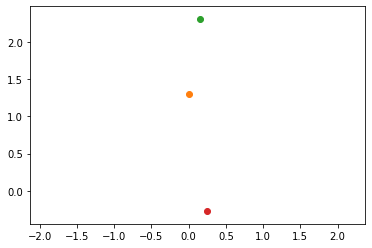

In [177]:
endTime = 1000
a = 0
#
#for a in range(numberOfSims):
stepFrequency = .1 # how often should a step occur (years)
steps = int(endTime/stepFrequency) # Will round down to an integer
print(f"Steps: {steps}")
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 0)
quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = steps, asteroidCollect = True)


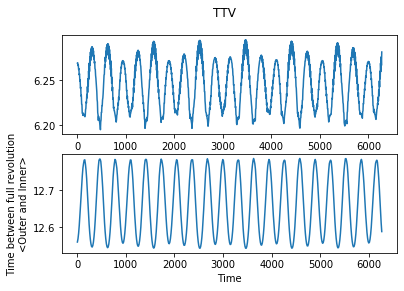

In [178]:
def ttvLinearApprox(data, times):
    """
    Transit timing variation. Detects the time at which the planet crosses the
    positive x-axis. 
    """
    global innertimes, outertimes
    innertimes = []
    outertimes = []
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        # Deleting the last row is one way to avoid an index error
        if x[0] < 0 and data[i+1][0] > 0: #for inner planet
            slope = (data[i+1][0]-data[i][0])/(times[i+1]-times[i])
            linearApprox = times[i+1]-data[i+1][0]/slope
            #(times[i]+times[i+1])/2
            innertimes.append(linearApprox)
        if x[1] < 0 and data[i+1][1] > 0: #for outer planet
            #averageT = (times[i]+times[i+1])/2
            slope = (data[i+1][1]-data[i][1])/(times[i+1]-times[i])
            linearApprox = times[i+1]-data[i+1][1]/slope
            outertimes.append(linearApprox)
            
    # The following measures the time difference between each succesive transit.
    global innertimesdif, outertimesdif
    innertimesdif = []
    for i in range(1,len(innertimes)):
        dif = innertimes[i]-innertimes[i-1]
        innertimesdif.append(dif)
    outertimesdif = []
    for i in range(1,len(outertimes)):
        dif = outertimes[i]-outertimes[i-1]
        outertimesdif.append(dif)
        
    # Graphs the difference with respect to the simulation time in which it occured.
    fig, axs = plt.subplots(2,1)
    fig.suptitle('TTV')
    axs[0].plot(innertimes[:len(innertimes)-1], innertimesdif)
    axs[1].plot(outertimes[:len(outertimes)-1], outertimesdif)
    plt.xlabel('Time')
    plt.ylabel('Time between full revolution\n<Outer and Inner>')
end = None
ttvLinearApprox(relative_y_value[0:end],times[0:end])

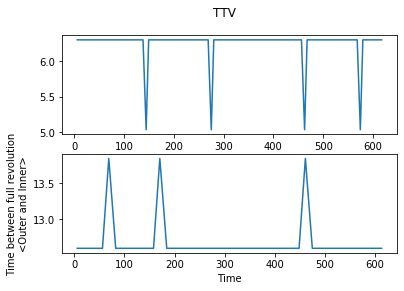

In [158]:
def ttv(data, times):
    """
    Transit timing variation. Detects the time at which the planet crosses the
    positive x-axis. 
    """
    global innertimes, outertimes
    innertimes = []
    outertimes = []
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        # Deleting the last row is one way to avoid an index error
        if x[0] < 0 and data[i+1][0] > 0: #for inner planet
            averageT = (times[i]+times[i+1])/2
            innertimes.append(averageT)
        if x[1] < 0 and data[i+1][1] > 0: #for outer planet
            averageT = (times[i]+times[i+1])/2
            outertimes.append(averageT)
            
    # The following measures the time difference between each succesive transit.
    global innertimesdif, outertimesdif
    innertimesdif = []
    for i in range(1,len(innertimes)):
        dif = innertimes[i]-innertimes[i-1]
        innertimesdif.append(dif)
    outertimesdif = []
    for i in range(1,len(outertimes)):
        dif = outertimes[i]-outertimes[i-1]
        outertimesdif.append(dif)
        
    # Graphs the difference with respect to the simulation time in which it occured.
    fig, axs = plt.subplots(2,1)
    fig.suptitle('TTV')
    axs[0].plot(innertimes[:len(innertimes)-1], innertimesdif)
    axs[1].plot(outertimes[:len(outertimes)-1], outertimesdif)
    plt.xlabel('Time')
    plt.ylabel('Time between full revolution\n<Outer and Inner>')
ttv(relative_y_value,times)

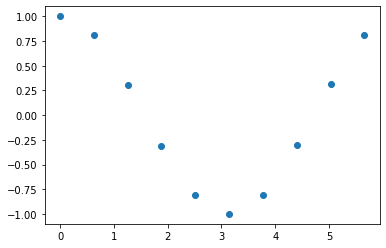

In [170]:
plt.plot(times[0:10],relative_x_value[0:10,0], 'o')

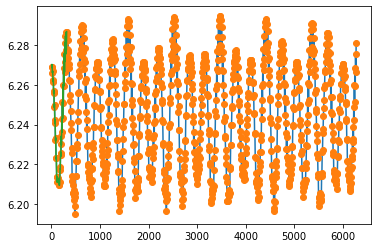

In [171]:
end = None
from scipy.interpolate import interp1d
plt.plot(innertimes[:len(innertimes)-1][0:end], innertimesdif[0:end])
plt.plot(innertimes[:len(innertimes)-1][0:end], innertimesdif[0:end],'o')
f2 = interp1d(innertimes[:len(innertimes)-1], innertimesdif, kind='cubic')
x = innertimes[:len(innertimes)-1][0:50]
xnew = np.linspace(x[0], x[-1], num=10000, endpoint=True)
plt.plot(xnew, f2(xnew), '-')

[-0.03894983  0.01931102 -1.19161482  6.24592119]


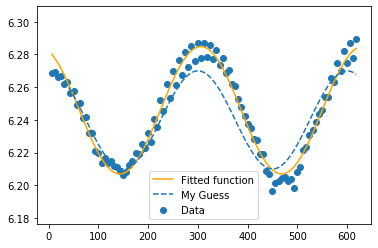

In [176]:
###############################
# I learned it was important to fine tune p0 if the optimize function gave bad params
###############################
from scipy import optimize
x_data, y_data = innertimes[:len(innertimes)-1][0:end], innertimesdif[0:end]
def test_func(x, a, b,c,d):
    return a * np.sin(b * x + c)+d

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,#,
        p0=[-.03,1/300*2*np.pi,-np.pi/2,6.24])
print(params)


plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
# plt.plot(x_data, test_func(x_data, params[0], params[1], params[2]),
#          label='Fitted function')

plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
         label='Fitted function', color = 'orange')
params = [-.03,1/300*2*np.pi,-np.pi/2,6.24]
plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
        "--",label = "My Guess")

plt.legend(loc='best')

plt.show()

[-0.03625166  0.12492456 -1.48494307  6.24455576]


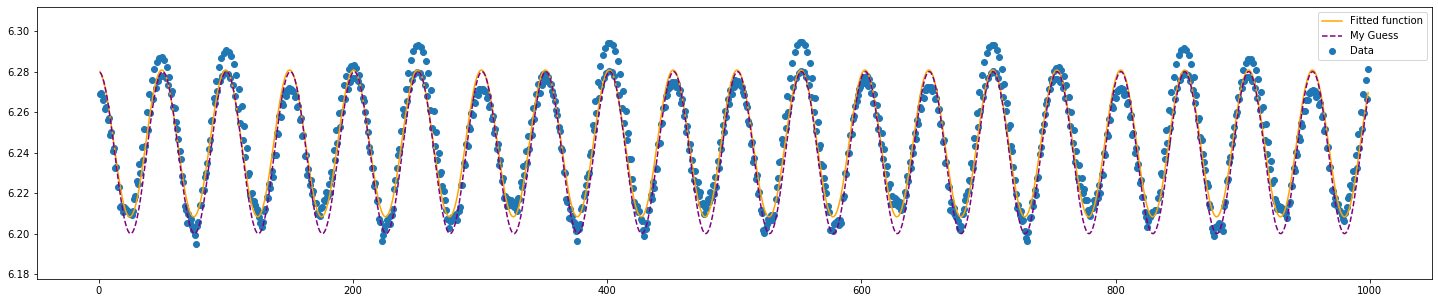

In [230]:
end = None
from scipy import optimize
x_data, y_data = [time/tau for time in innertimes[:len(innertimes)-1][0:end]], innertimesdif[0:end]
def test_func(x, a, b,c,d):
    return a * np.sin(b * x + c)+d

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
        p0=[-.04,1/8,-np.pi/2,6.24])
print(params)


plt.figure(figsize=(25, 5))
plt.scatter(x_data, y_data, label='Data')
# plt.plot(x_data, test_func(x_data, params[0], params[1], params[2]),
#          label='Fitted function')

plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
         label='Fitted function', color = 'orange')
params = [-.04,1/8,-np.pi/2,6.24]
plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
        "--",label = "My Guess", color = 'purple')

plt.legend(loc='best')

plt.show()

In [188]:
innertimes[100]

630.6858227034372